In [1]:
import lightkurve as lk
from astropy import units as u
import numpy as np

In [2]:
data = np.loadtxt("/Users/Oliver/Desktop/PSD_all.pow")
data

array([[4.2721713e-02, 3.7304220e+03],
       [8.5443426e-02, 2.8466775e+03],
       [1.2816514e-01, 5.5721785e+02],
       ...,
       [4.1666487e+03, 3.6161836e-01],
       [4.1666914e+03, 1.0425408e+00],
       [4.1667341e+03, 1.3693696e+00]])

In [3]:
v = data[..., 0] * u.uHz
v

<Quantity [4.2721713e-02, 8.5443426e-02, 1.2816514e-01, ..., 4.1666487e+03,
           4.1666914e+03, 4.1667341e+03] uHz>

In [4]:
P = u.Quantity(data[..., -1], u.cds.ppm**2/u.uHz)
P

<Quantity [3.7304220e+03, 2.8466775e+03, 5.5721785e+02, ..., 3.6161836e-01,
           1.0425408e+00, 1.3693696e+00] ppm2 / uHz>

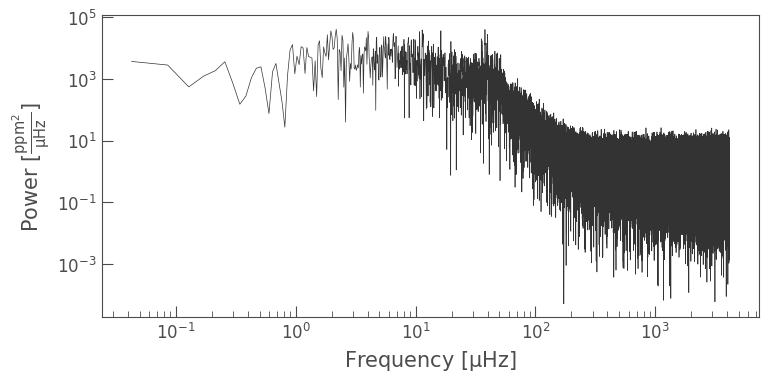

In [5]:
pg = lk.Periodogram(v, P)
%matplotlib inline
pg.plot(scale='log');

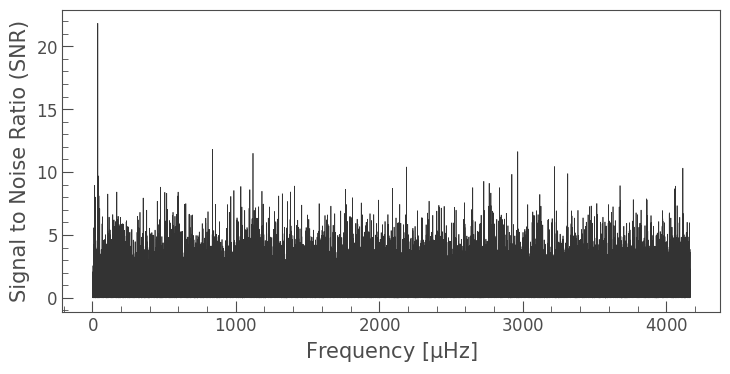

In [6]:
snr = pg.flatten()
snr.plot()

In [7]:
seis = snr.to_seismology()

In [8]:
seis.estimate_numax()

ValueError: the ACF 2D method requires that the periodogram has a grid of uniformly spaced frequencies.

In [9]:
seis.estimate_deltanu(numax = 100)

ValueError: the ACF 2D method requires that the periodogram has a grid of uniformly spaced frequencies.

## Joel's changes

In [10]:
N = len(v)
vf = (np.arange(N) + 1) * np.mean(np.diff(v))
vf

<Quantity [4.27217129e-02, 8.54434257e-02, 1.28165139e-01, ...,
           4.16664866e+03, 4.16669138e+03, 4.16673410e+03] uHz>

In [11]:
pgf = lk.Periodogram(vf, P)
seisf = pgf.flatten().to_seismology()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x127eecb10>,
      dtype=object)

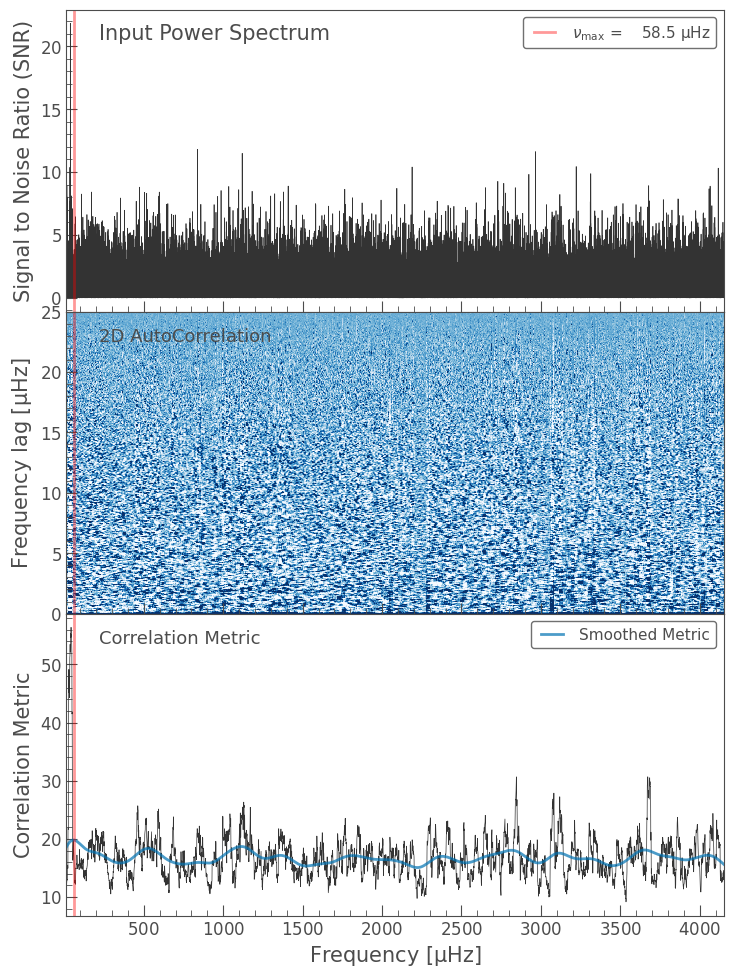

In [12]:
seisf.estimate_numax(spacing=1, window_width=25)
seisf.diagnose_numax()

## and with a cut-up frequency

array([<matplotlib.axes._subplots.AxesSubplot object at 0x138fdc390>,
      dtype=object)

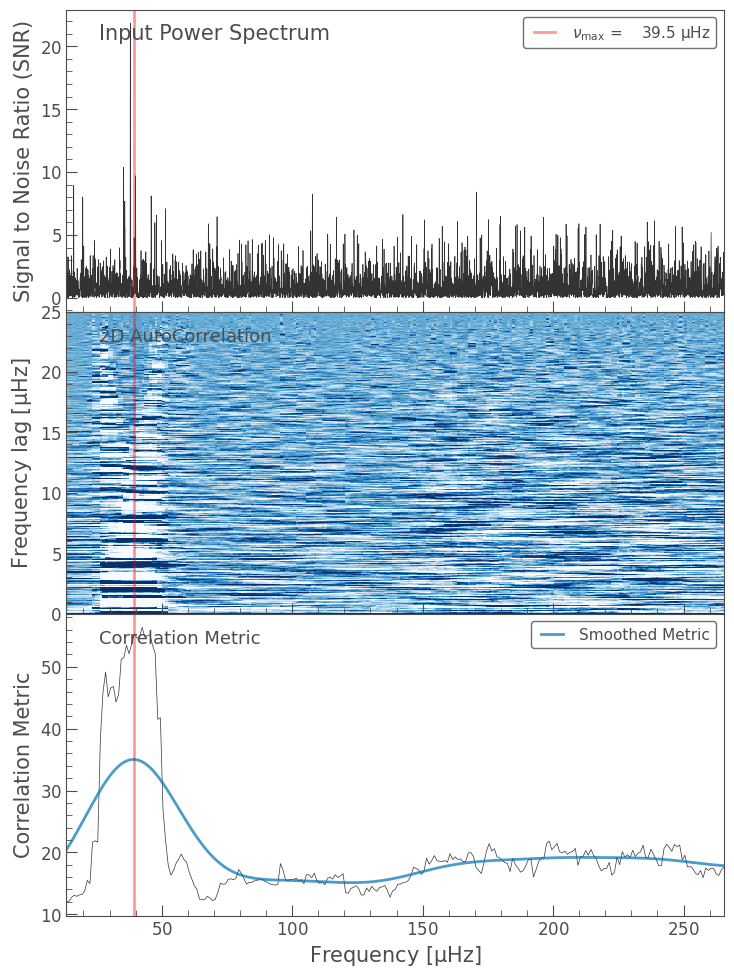

In [13]:
m = vf.value<280
pgs = lk.Periodogram(vf[m], P[m])
seiss = pgs.flatten().to_seismology()
seiss.estimate_numax(window_width=25, spacing=1)
seiss.diagnose_numax()

## Pytst

In [14]:
def generate_test_spectrum():
    """Generates a simple solar-like oscillator spectrum of oscillation modes
    """
    f = np.arange(0, 4000., 0.4)
    p = np.ones(len(f))
    nmx = 2500.
    fs = f.max()/len(f)

    s = 0.25*nmx/2.335    #std of the hump
    p *= 10 * np.exp(-0.5*(f-nmx)**2/s**2)  #gaussian profile of the hump

    m = np.zeros(len(f))
    lo = int(np.floor(.5*nmx/fs))
    hi = int(np.floor(1.5*nmx/fs))

    deltanu_true = 0.294 * nmx ** 0.772
    modelocs = np.arange(lo, hi, deltanu_true/2, dtype=int)

    for modeloc in modelocs:
        m += deltafn(len(f), modeloc)
    p *= m
    p += 1
    return f, p, nmx, deltanu_true


In [18]:
from scipy.signal import unit_impulse as deltafn
from lightkurve.periodogram import SNRPeriodogram

f, p, true_numax, _ = generate_test_spectrum()
f += np.random.uniform(size=len(f))
snr = SNRPeriodogram(f*u.microhertz, u.Quantity(p, None))

In [33]:
import pytest
with pytest.raises(ValueError) as exc:
    numax = snr.to_seismology().estimate_numax()
assert "uniformly spaced" in str(exc.value)

ValueError('the ACF 2D method requires that the periodogram has a grid of uniformly spaced frequencies.')